# Understanding Flow Matching - A hands-on Julia implementation

Diffusion models have been quite the hype in these last years. 
I first noticed them when DALLE-generated images were posted all over twitter, showing e.g. photorealistic horses on the moon or 19th century paintings of modern Tokyo. Other models such as Stable Diffusion or Midjourney soon followed with similar results.
Nowadays everyone knows how to easily generate pretty images with ChatGPT, and we even regularly encounter AI-generated videos on social media with quite an impressive quality.
But what adds to the hype for me is that diffusion models are actually also used outside of images and videos, _in science_, e.g. for 
time series forecasting 
[[link]](https://arxiv.org/abs/2404.18886),
weather forecasting
[[link]](https://arxiv.org/abs/2312.15796)
fluid flow simulations
[[link]](https://openreview.net/forum?id=uKZdlihDDn),
data assimilation
[[link]](https://arxiv.org/abs/2306.10574),
molecule generation
[[link]](https://www.nature.com/articles/s41467-024-46569-1),
and much more.
So, diffusion models do seem pretty cool and useful!

Now it turns out that diffusion models are closey related to _flow matching_, and a colleague of mine recommended the 
[Flow Matching Guide and Code](https://arxiv.org/abs/2412.06264)
paper to me as a good first introduction into the topic.
So, in this blog post I will work through the "Quick tour and key concepts" section of this paper and then implement their simple flow matching model, _in Julia_.

My main goal with this post is to actually learn about diffusion models and flow matching myself — and the best way for me to do so is by coding and writing!
But to do so, I'm aiming to explain all the math very clearly and write code that matches the math as closely as possible.
This means that I'll not use any specialized diffusion or flow matching packages, and I'll only rely on basic libraries for 
neural networks ([Lux.jl](https://lux.csail.mit.edu/stable/)), 
optimization ([Optimization.jl](https://docs.sciml.ai/Optimization/stable/)), 
and 
differential equations ([DifferentialEquations.jl](https://docs.sciml.ai/DiffEqDocs/stable/)). 
Maybe this presentation could also be beneficial to other that aim to get into the topic!

So, let's get started!

<The parts below are complete, but not yet properly formulated for the blog post>

## Generative models and flow matching

High-level our goal is to build a model that can generate new data points that are indistinguishable from the training data (e.g. images).
In math, this means that we assume that some given dataset $X = \{x_1, x_2, \ldots, x_N\}$ is drawn from some unknown, true distribution $q(x)$,
and we want to learn a model $p(x)$ that approximates this true underlying distribution $q(x)$.
Then, once we have learned the model $p(x)$, we can sample from it to generate new data points.

Flow matching is one particular class of generative models for learning such a distribution.
On a very high level, flow matching models construct a mapping from a simple, known distribution $p_0(x)$ (e.g. Gaussian) to the target distribution $q(x)$,
by learning a _velocity field_ $u(x, t)$ that describes how samples should be moved from the simple distribution to the target distribution.

### Ordinary differential equations and probability flows
Consider a simple ordinary differential equation (ODE) of the form
$$\dot{\xi}(t) = u(t, \xi(t)).$$
This ODE implicitly defines by the time-dependent *flow*
$\psi: [0, 1] \times \mathbb{R}^d \to \mathbb{R}^d,$
which maps an initial value $\xi(0)=\xi_0$ to the corresponding ODE solution at time $t$. 

In addition, given a probability distribution $p_0$ over possible initial values for the ODE,
the flow map defines a probability path $p_t$ as
$$p_t(x) = \psi_t^* p_0(x) = \int_{\mathbb{R}^d} p_0(y) \delta(\psi(t, y) - x) \mathrm{d}y,$$
where $\psi_t^*$ is the pushforward operator of the flow $\psi$.
Or in more simple terms:
If $X_0 \sim p_0$, then $X_t := \psi(t, X_0) \sim p_t$.

Thus, ODEs provide a nice way to define a continuous *flow* of probability distributions $(p_t)_{0 \leq t \leq 1}$
from an initial distribution $p_0$ to a distribution $p_1$.

## Flow Matching

The goal in flow matching is now to learn a velocity field $u_\theta$, typically a neural network, that generates a probability path $(p_t)_{t \in [0, 1]}$ which 
interpolates between the simple, known distribution $p_0$ and the target distribution $p(t)$.
We will do this in two steps:
1. Design a probability path $p_t$ interpolating between $p$ and $q$,
2. Train a velocity field $u_\theta$ generating $p_t$ via regression.

### Step 1: Designing the probability path

In this example we choose a source distribution $p = p_0 = \mathcal{N}(x; 0, I)$,
and we define the probability path as follows:
$$p_t(x) = \int p_{t|1}(x|x_1) q(x_1) \mathrm{d}x_1,$$
where $p_{t|1}(x|x_1) = \mathcal{N}(x; tx_1, (1-t)^2 I).$
This is also known as the *conditional optimal-transport* or *linear* path.

Using this path, we may define the random variable $X_t \sim p_t$ by drawing $X_0 \sim p$, $X_1 \sim q$, and taking their linear combination:
$$X_t = t X_1 + (1-t) X_0 \sim p_t.$$

### Step 2: Training the velocity field $u_\theta$

We now want to approximate the velocity field $u_t$, which generates the desired probability path $p_t$, with a parameterized model $u_\theta$.

The *Flow Matching loss* that describes this regression problem in general reads as follows:
$$\mathcal{L}_\text{FM}(\theta) = \mathbb{E}_{t, X_t} \| u_t^\theta(X_t) - u_t(X_t) \|^2,$$
where $t \sim \mathcal{U}[0,1] \text{ and } X_t \sim p_t.$
But in practice, this can rarely be implemented as $u_t$ is too complicated.
But if we condition the loss on a single target example $x_1$, picked at random from the training set, the objective simplifies and becomes tractable:
Recall the that we defined the conditional probability path above as 
$p_{t|1}(x|x_1) = \mathcal{N}(x; t x_1, (1-t)^2 I)$.
We then solve for $\frac{\mathrm{d}}{\mathrm{d}t} X_{t|1} = u_t ( X_{t|1} | x_1)$.
First, note that
$$
\begin{align}
\frac{\mathrm{d}}{\mathrm{d}t} X_{t|1} 
&= \frac{\mathrm{d}}{\mathrm{d}t} \left( t x_1 + (1-t) X_0 \right) \\
&= x_1 - X_0.
\end{align}
$$
Then, substituting in $X_0 = \frac{X_{t|1} - t x_1}{1-t}$, we get
$$
\begin{align}
\frac{\mathrm{d}}{\mathrm{d}t} X_{t|1} 
&= x_1 - \frac{X_{t|1} - t x_1}{1-t} \\
&= \frac{x_1 - X_{t|1}}{1-t}.
\end{align}
$$
Thus, the *conditional velocity field* that corresponds to our chosen probability path is
$$u_t(x|x_1) = \frac{x_1 - x}{1 - t}.$$

We can now define the *conditional Flow Matching loss*:
$$\mathcal{L}_\text{CFM}(\theta) = \mathbb{E}_{t, X_t, X_1} \| u_t^\theta(X_t) - u_t(X_t|X_1) \|^2,$$
where $t \sim \mathcal{U}[0,1],\ X_0 \sim p,\ X_1 \sim q,\ X_t=(1-t) X_0 +t X_1.$
Remarkably, both objectives provide the same gradients to learn $u_t^\theta$, i.e. $\nabla_\theta \mathcal{L}_\text{FM}(\theta) = \nabla_\theta \mathcal{L}_\text{CFM}(\theta)$.

To conclude, we put the vector field $u_t(x|x_1)$ into the loss and obtain the simplest implementation of Flow Matching:
$$\mathcal{L}_\text{CFM}^\text{OT,Gauss}(\theta) = \mathbb{E}_{t, X_0, x_1} \| u_t^\theta(X_t) - (X_1 - X_0) \|^2,$$
where $t \sim \mathcal{U}[0,1],\ X_0 \sim p,\ X_1 \sim q.$

## Simple Flow Matching in Code

We will now implement the above algorithm in a simple example on the well-known two-moons data:

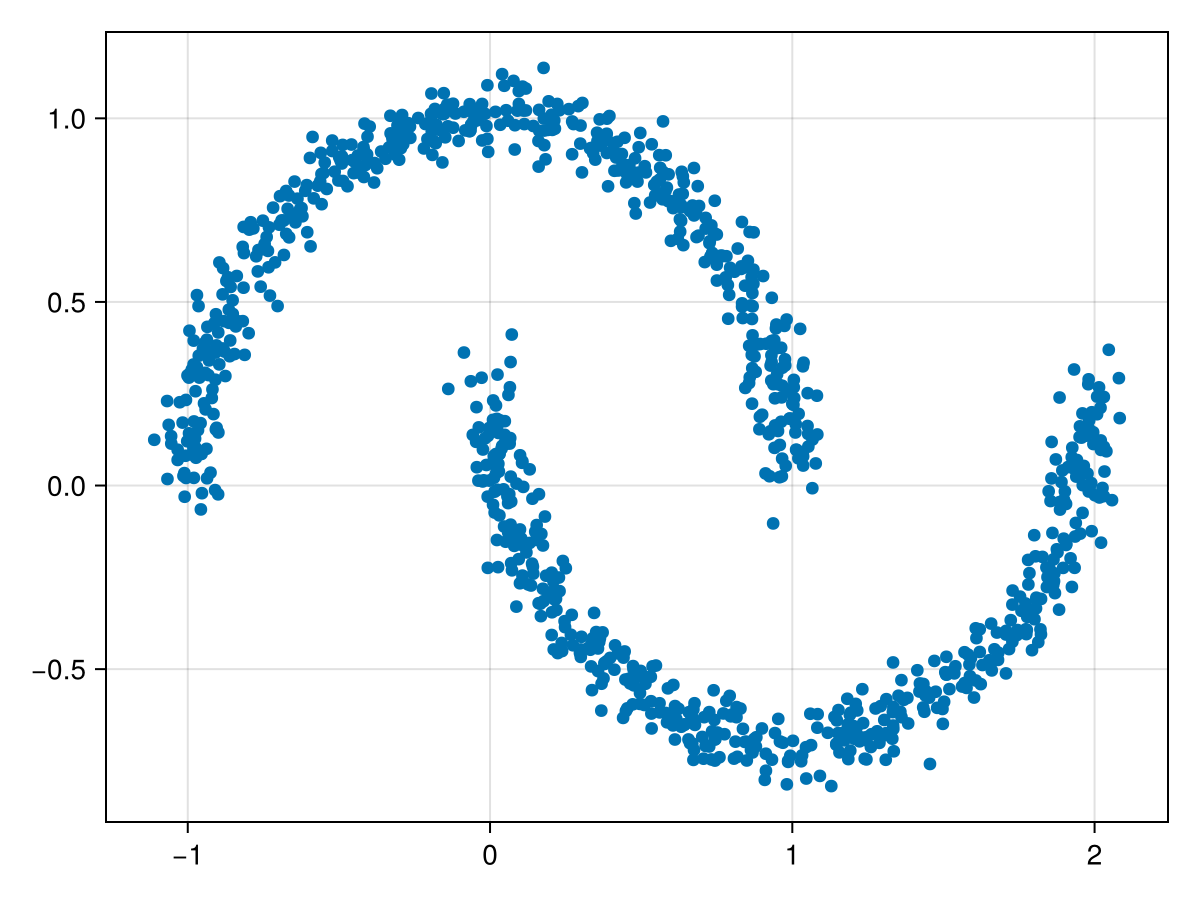

In [1]:
using MLJBase, CairoMakie

X, _ = make_moons(1024; noise=0.05)
X = collect.(MLJBase.Tables.rows(X))

scatter(
    [x[1] for x in X], [x[2] for x in X], 
)

We approach the implementation in the following steps.
1. First, we implement the **velocity field** by building a neural network in [Lux.jl](https://lux.csail.mit.edu/stable/). We will follow the architecture provided in the corresponding example in the paper.
2. Then, we implement the **training objective**, i.e. the loss function we discussed above. 
3. We then **learn the neural network parameters** by minimizing this loss function with [Optimization.jl](https://docs.sciml.ai/Optimization/stable/). We obtain the model parameters of a velocity field which should be close to the target velocity field.
4. We evaluate the resulting model by **drawing samples $X_0 \sim p$ and propagating them forward through the velocity field** to check if the resulting samples match the target distribution $q$. We do this by solving the corresponding ODE wiht [OrdinaryDiffEq.jl](https://github.com/SciML/OrdinaryDiffEq.jl).

Other packages that we'll rely on include [ComponentArrays.jl](https://docs.sciml.ai/ComponentArrays/stable/) for convenient parameter handling, [Plots.jl](https://docs.juliaplots.org/latest/tutorial/) for plotting, [SimpleUnPack.jl](https://github.com/devmotion/SimpleUnPack.jl) for conveniently unstructuring named tuples,

In [2]:
# General packages
using Random, SimpleUnPack
import ComponentArrays

**1. Define the neural network velocity field.**

In [3]:
using Lux, NNlib

hidden = 64
model = Chain(
    ((x, t),) -> vcat(x, t),
    Dense(2 + 1, hidden, NNlib.elu),
    Dense(hidden, hidden, NNlib.elu),
    Dense(hidden, hidden, NNlib.elu),
    Dense(hidden, 2),
)
model = f64(model)

rng = Random.default_rng()
ps, st = Lux.setup(rng, model)
ps = Float64.(ComponentArrays.ComponentArray(ps));

**2. Define the loss function as derived above.**

In [4]:
BATCH_SIZE = 256

function loss_fn(ps, other_params)
    st = other_params.st
    # sample x1 randomly from the dataset X
    x1 = rand(X, BATCH_SIZE) |> stack 
    # sample x0 from N(0,I) with the same size as x1
    x0 = randn(size(x1, 1), BATCH_SIZE)
    # sample t in [0,1]
    t = rand(1, BATCH_SIZE)
    # compute xt
    xt = @. (1-t)*x0 + t*x1
    # apply model to evaluate the vector field
    dut, _ = Lux.apply(model, (xt, t), ps, st)
    # the true vector field is (x1-x0)
    dut_true = x1 - x0
    # return MSE loss
    return MSELoss()(dut, dut_true)
end

loss_fn (generic function with 1 method)

**3. Define the optimization problem and solve it.**

In [5]:
using Optimization, OptimizationOptimisers, Enzyme, Zygote

adtype = Optimization.AutoZygote()
optf = OptimizationFunction(loss_fn, adtype)
optprob = OptimizationProblem(optf, ps, (st=st,));

In [6]:
function callback(state, loss_val)
    if state.iter % 100 == 0
        @info "Iteration: $(state.iter), Loss: $loss_val"
    end 
    return false
end 

callback (generic function with 1 method)

In [7]:
optsol = Optimization.solve(
    optprob,
    Adam(1e-2),
    maxiters=10000,
    # maxiters=10,
    callback=callback,
)

┌ Info: Iteration: 100, Loss: 1.0475364185055667
└ @ Main /home/user/projects/nathanaelbosch.github.io/posts/flow-matching/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X23sZmlsZQ==.jl:3
┌ Info: Iteration: 200, Loss: 1.0687442707088826
└ @ Main /home/user/projects/nathanaelbosch.github.io/posts/flow-matching/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X23sZmlsZQ==.jl:3
┌ Info: Iteration: 300, Loss: 1.0781331814844148
└ @ Main /home/user/projects/nathanaelbosch.github.io/posts/flow-matching/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X23sZmlsZQ==.jl:3
┌ Info: Iteration: 400, Loss: 1.2592073167985558
└ @ Main /home/user/projects/nathanaelbosch.github.io/posts/flow-matching/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X23sZmlsZQ==.jl:3
┌ Info: Iteration: 500, Loss: 1.0942017321228052
└ @ Main /home/user/projects/nathanaelbosch.github.io/posts/flow-matching/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X23sZmlsZQ==.jl:3
┌ Info: Iteration: 600, Loss: 0.9716505519253

retcode: Default
u: ComponentVector{Float64}(layer_1 = Float64[], layer_2 = (weight = [1.1129676598545717 -0.26636516625496626 -0.6949375287296221; 1.452736526241441 -0.9094375218402786 -0.5366332504450944; … ; -0.8976253081417169 0.22842876390985167 -0.4307228516843694; 0.007614216183257934 -0.013111739251943736 -0.023030756578065317], bias = [-0.6933546010178161, 0.6825391507289289, -0.08345527014464973, 0.0337836894945836, 0.09821186521385702, 0.09709495444354764, -0.0821572996290557, 0.395653947452437, 0.7583181669852151, -0.5950245950318485  …  0.321269774648287, -0.4777181297868182, -0.15845442953961258, -0.7229021767270207, 0.11062142534357375, 0.8412181618990443, 0.7216221064656311, -0.04480899079635413, 0.16046798927377812, 0.012559313755784448]), layer_3 = (weight = [-0.2567923936596478 -0.461571246007995 … -0.12947535485380152 -0.07938947080947106; 0.04219877849254649 -0.46042132615094666 … -0.011731803740445483 -0.0696097081857016; … ; 0.0437259037109223 -0.1583138766908733

**4. Evaluate the resulting model by solving the corresponding differential equation.**

In [8]:
using OrdinaryDiffEq

function f(u, p, t)
    _t = t * ones(1, size(u, 2))
    du, _ = Lux.apply(model, (u, _t), p.ps, st)
    return du
end
u0 = randn(2, 256)
tspan = (0.0, 1.0)
p = (ps=optsol.u,)

odeprob = ODEProblem(f, u0, tspan, p);

In [9]:
odesol = solve(odeprob, Tsit5(), saveat=range(tspan[1], tspan[2], length=6));

Let's plot how the samples evolve over time:

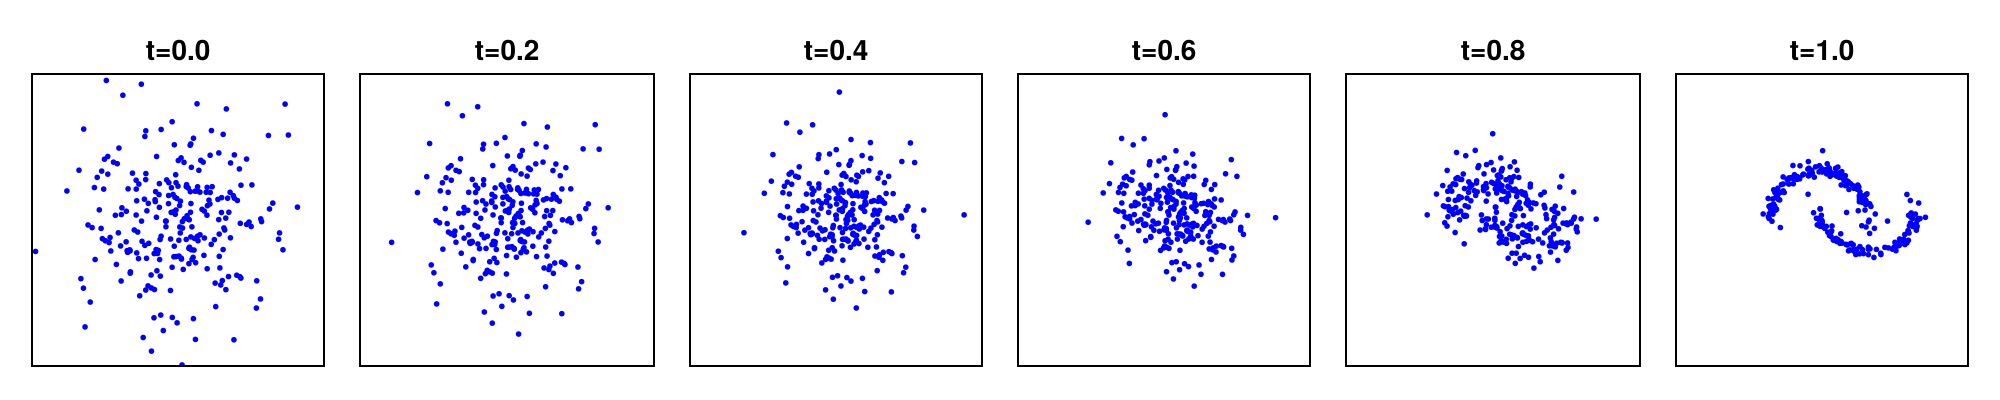

In [10]:
fig = Figure(size=(1000, 200))
axes = [
    Axis(fig[1, i], 
        title="t=$(odesol.t[i])", 
        aspect=AxisAspect(1),
    ) for i in 1:length(odesol)
]
for i in 1:length(odesol)
    _t, _u = odesol.t[i], odesol.u[i]
    ax = axes[i]

    scatter!(
        ax, 
        odesol.u[i][1, :], odesol.u[i][2, :], 
        color=:blue, markersize=4,
    )
    hidedecorations!(axes[i])
    xlims!(ax, (-3, 3))
    ylims!(ax, (-3, 3))

    #f(u) = Point2f(f(u, (ps=ps,), _t)...)
    #streamplot!(ax, f, -3..3, -3..3, colormap = :magma, alpha=0.2)
end

fig